In [30]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
from pytz import timezone
import pytz
from pymongo import MongoClient
import pymongo
import re
import sys
from decimal import *
from gensim import corpora
import time
import networkx as nx
import LDA
reload(LDA)
from LDA import *
import matplotlib.pyplot as plt
%matplotlib inline

jst = timezone('Japan')
is_overwrite = False #　True: 上書き; False: 上書きしない .optionでバリューを設定可能
condid = None
# start_date_str = '2016-03-0100:00:00'
# end_date_str = '2016-03-0123:59:59'
start_date_str = '2016-07-1100:00:00'
end_date_str = '2016-09-2723:59:59'
ISOTIMEFORMAT = '%Y-%m-%d%H:%M:%S'
start_date = dt.strptime(start_date_str, ISOTIMEFORMAT).replace(tzinfo=jst)
end_date = dt.strptime(end_date_str, ISOTIMEFORMAT).replace(tzinfo=jst)


In [31]:
# DBコネクション作成
client = MongoClient("localhost", 27017)
db = client["vieureka2"]

In [32]:
# layout_opt_condコレクションに指定時間のデータが存在するかのチェック
res = db['layout_opt_cond'].find({'time_from':start_date, 'time_to':end_date}, {'_id':1})
for item in res:
    condid = item['_id']
# 重複データ存在かつ上書きしないの場合そのまま終了
if not is_overwrite  and  condid != None:
    print '設定された期間は既に登録済みです。\n'\
          '※上書き実行する場合には『-o』オプションをご指定ください。'
    sys.exit()

In [33]:
# 要　検討
shelfid_list = db['shelf'].distinct('_id')
shelf_dic = {}
for shelf in shelfid_list:
    node_tmps = []
    for obj in db.node.aggregate([{'$match': {'shelf_id': shelf} },{'$group':{'_id':{'node_id':'$_id'}}}]):
        node_tmps.append(int(obj['_id']['node_id']))
    shelf_dic[shelf] = node_tmps

node_all_shelfs = set(db['node'].distinct('shelf_id'))
# 要　検討

Connection = {}
node_id = {u'Unk': 0,}
# area_id の座標テーブル作成
Area = {}
res = db['node'].find().sort([('x',pymongo.ASCENDING), ('y',pymongo.ASCENDING)])
idx = 1
for item in res:
    Area[int(item['_id'])] = {'x': item['x'], 'y':item['y']}
    adjacent = []
    for i in item['adjacent_nodes']:
        adjacent.append(int(i))
    Connection[int(item['_id'])] = adjacent
    node_id[item['_id']] = idx
    idx += 1

In [34]:
# 店内の移動可能エリアのグラフ化
G = nx.Graph()
for k in np.sort(Connection.keys()):
    id = k
    #node座標の中心点
    pos = [Area[id]['x'], Area[id]['y']]
    G.add_node(k,pos=pos, count=0)
    for e in Connection[k]:
        G.add_edge(k,e,weight=0)
default_weight = nx.get_edge_attributes(G, 'weight').copy()

In [35]:
# 隣接ノード間の実距離を格納する
nx.set_edge_attributes(G, 'dist', default_weight)
node_dist = default_weight.copy()
pos = nx.get_node_attributes(G, 'pos')
for i,j,attr in G.edges_iter(data=True):
    if 'dist' in attr:
        d = np.array(pos[i]) - np.array(pos[j])
        node_dist[(i,j)] = np.sqrt(sum(d*d))
nx.set_edge_attributes(G, 'dist', node_dist)

## 購買品および購買行動を 「文章」化する

In [36]:
matcher = {'$and':[{'start_date': {'$gte': start_date}}, {'end_date': {'$lt': end_date}}, {'data.status':2}]}
res = db['track'].find(matcher,{'_id':1, 'data.status':1}).sort('_id', pymongo.ASCENDING)
out1 = []
basket_id_track = []
out1 = []
for item in res:
    count = 0
    for data in item['data']:
        if data['status'] == 2:                                                                        
            count += 1       
    if count:
        out1.append((item['_id'], count))
        basket_id_track.append(item['_id'])
        

matcher = {'$and': 
              [
                  {'basket_id':{'$in': basket_id_track}},
                  {'date': {'$gte': start_date, '$lt': end_date}}
              ]
          }
res = db['pos'].aggregate([
                    { '$match': matcher},
                    { '$group':{
                        '_id': {'basket_id': '$basket_id'},
                        'count': {'$sum': 1}
                    }},
                    { '$sort' : {'_id.basket_id' : pymongo.ASCENDING} },
                ])
out2 = []
basket_id_pos = []
for item in res:
    out2.append((item['_id']['basket_id'], item['count']))
    basket_id_pos.append(item['_id']['basket_id'])
basket_id_diff = list(set(basket_id_track) - set(basket_id_pos))
temp = []
for item in out1:
    if item[0] not in basket_id_diff:
        temp.append(item)
out1 = temp
temp = []
for item in out2:
    if item[0] not in basket_id_diff:
        temp.append(item)
out2 = temp
out1 = tuple(out1)
out2 = tuple(out2)
rct = np.c_[out1, out2][:, [0,1,3]]
print len(out1), len(out2)

0 0


In [27]:
#　商品カテゴリIDを配列インデックスに変換するためのテーブル作成
pos_dic = []
for i in range(rct.shape[0]): 
    matcher = {'$and': 
                  [
                      { 'date': {'$gte': start_date, '$lt': end_date}},
                      { 'basket_id': rct[i,0] }
                  ]
              }
    res = db['pos'].find(matcher, {'cat_id':1}).sort('cat_id', pymongo.ASCENDING)
    for item in res:
        pos_dic.append(item['cat_id'])
pos_dic = np.unique(pos_dic).tolist()

In [28]:
# 各レシートに現れる購買品を単語列として、レシート＝文書とする

pos_repeat = True # 複数購入を重みとして考慮するか
pos_doc = []
for i in range(rct.shape[0]):
    matcher = {'$and': 
                  [
                      { 'date': {'$gte': start_date, '$lt': end_date}},
                      { 'basket_id': rct[i,0] }
                  ]
              }
    if pos_repeat is True:
        res = db['pos'].find(matcher, {'cat_id':1, 'num':1})
    else:
        res = db['pos'].aggregate([
                    {'$match': matcher },
                    {'$group':{
                        '_id': {'cat_id': '$cat_id'},
                        'num': {'$sum': '$num'}
                    }}
                ])
    doc = []
    for item in res:
        #今回対象外のコメントアウト
#         if int(item['cat_id']) == 977 or int(item['cat_id']) == 978: # キャンペーン商品除外
#             continue
        if pos_repeat is True:
            for i in range(int(item['num'])): # 複数購入の場合は、その数の単語の繰り返しとする
                doc.append(pos_dic.index(str(item['cat_id'])))
        else:
            doc.append(pos_dic.index(str(item['cat_id'])))
    pos_doc.append(sorted(doc))

In [29]:
# 移動軌跡の欠落箇所を、店内グラフに基づいて補完する
def add_edge_count(G, orig):
    new = [track_dic.index(orig[0])]
    for i in range(1, len(orig)):
        path = nx.dijkstra_path(G, orig[i-1], orig[i], 'dist')
        for j in range(1, len(path)):
            new.append(track_dic.index(path[j]))
    return new

In [11]:
# 買い物客が見ていた棚情報に基づいて、買い回り行動を「文書」化する
# (「単語」は見ていた棚に対応)
track_dic = []
# res = db['node'].find({},{'shelf_id':1})
# for item in res:
#     for shelf in item['shelf_id']:
#         if shelf not in track_dic:
#             track_dic.append(shelf)
track_dic = db['node'].distinct('shelf_id')

track_doc = []
for i in range(rct.shape[0]):
    matcher = {'$and': 
                  [
                      { 'data.status': {'$gt' : 0} },
                      { 'data.ts': {'$gte': start_date, '$lt': end_date}},
                      { '_id': rct[i,0] }
                  ]
              }
    res = db['track'].find(matcher, {'data':1}).sort([('data.ts',pymongo.ASCENDING),('data.ts_ms',pymongo.ASCENDING)])
    doc = []
    for item in res:
        # 対象外の為コメントアウト
        #if item['shelf_id'] == 48 or item['shelf_id'] == 49: #　レジ滞在除外
             #continue
        for data in item['data']:
#             if data['dept'] == 48 or data['dept'] == 49: #　レジ滞在除外
#                 continue
            if int(data['status']) == 2:
                doc.append(track_dic.index(data['shelf_id']))
            elif int(data['status']) == 1:
                for r in db['node'].distinct('shelf_id', {'_id':data['node_id']}):
                    doc.append(track_dic.index(r))
    track_doc.append(doc)

In [12]:
# 移動軌跡に基づいて、買い回り行動を「文書」化する
#  (「単語」は店内のエリアＩＤに対応)
track_dic = range(1, len(node_id)+1)
track_doc = []

for i in range(rct.shape[0]):
    matcher = {'$and': 
                  [
                      { '_id': rct[i,0] },
                      { 'data.duration': {'$gt': 5}}
                  ]
              }
    res = db['track'].find(matcher, {'data.node_id':1, 'data.duration':1}).sort([('data.ts',pymongo.ASCENDING),('data.ts_ms',pymongo.ASCENDING)])
    doc = []
    #res = [x for x in res]   
    #if (len(res) == 0): 
    if res.count() == 0:
        track_doc.append([])
        continue
    for item in res:
        for data in item['data']:
            if data['duration'] > 5:
                value = node_id[str(data['node_id'])]
#                 if value == 0: # 未知エリア無視
#                     continue
#                 if value == 38 or value == 39: # レジ前無視
#                     continue
                doc.append(value)
        track_doc.append(doc)
print len(track_doc)
print len(pos_doc)

0
0


## マルチモーダルLDAでモデル推定

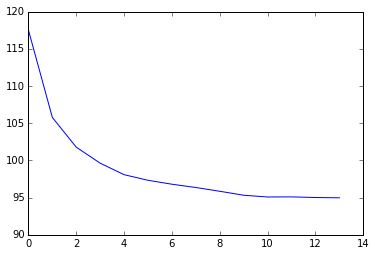

In [13]:
buffar_class = 20
max_class = 20
mlda = MLDA(buffar_class, 0.1, [0.1, 0.1], [pos_doc, track_doc], [len(pos_dic), len(track_dic)+1], seed=int(time.time()))
# mlda = MLDA(max_class, 0.1, [0.1, 0.1], [pos_doc, track_doc], [len(pos_dic), len(track_dic)+1], seed=int(time.time()))
perp = mlda.fit(threshold=5e-2)
plt.plot(perp)

### 最適トピック数の決定

In [14]:
# buff = []
# for n in [3, 5, 10, 15, 20, 30, 45, 60, 80]:
#     mlda = MLDA(n, .1, [0.1, 0.1], [pos_doc, track_doc], [len(pos_dic), len(track_dic)+1], seed=int(time.time()))
#     perp = mlda.fit(threshold=5e-2)
#     buff.append([n, perp[-1]])
# buff = np.array(buff)

In [15]:
# plt.plot(buff[:, 0], buff[:, 1], label='perplexity')
# plt.rcParams["font.size"] = 12
# plt.xlabel('number of groups')
# plt.ylabel('perplexity')
# plt.legend()

### クラスタリングの結果を確認

In [16]:
max_lbl = np.apply_along_axis(np.argmax, 1, mlda.topicdist())
rslt = np.empty((0, len(pos_dic)), dtype=float)
tmp = []
odr = []
for c in range(max_class):
    basket_id = rct[max_lbl==c, 0]
    pprob = np.zeros((len(basket_id), len(pos_dic)), dtype=float)
    for r in range(len(basket_id)):
        matcher = {'basket_id': basket_id[r] }
        if pos_repeat is True:
            res = db['pos'].find(matcher, {'cat_id':1, 'num':1})
        else:
            res = db['pos'].aggregate([
                    {'$match': matcher },
                    {'$group':{
                        '_id': {'cat_id': '$cat_id'},
                        'num': {'$sum': '$num'}
                    }}
                ])
            
        for item in res:
#             if int(res[j]['cat_id']) == 977 or int(res[j]['cat_id']) == 978: #　キャンペーン商品除外
#                 continue
            if pos_repeat is True:
                for i in range(int(item['num'])):
                    pprob[r, pos_dic.index(str(item['cat_id']))] += 1
            else:
                pprob[r, pos_dic.index(item['cat_id'])] += 1
    if len(pprob) != 0:
        pprob = np.apply_along_axis(lambda x: x/sum(x), 1, pprob)
        odr.append(np.argsort(np.apply_along_axis(np.mean, 0, pprob))[::-1][0])
        pprob = 1.0/(1.0 + np.exp(-20. * (pprob - .5)))
        tmp.append(pprob)          
    
for i in np.argsort(odr):
    rslt = np.r_[rslt, tmp[i]]
    rslt = np.r_[rslt, np.ones((1, len(pos_dic)), dtype=float)*2.]

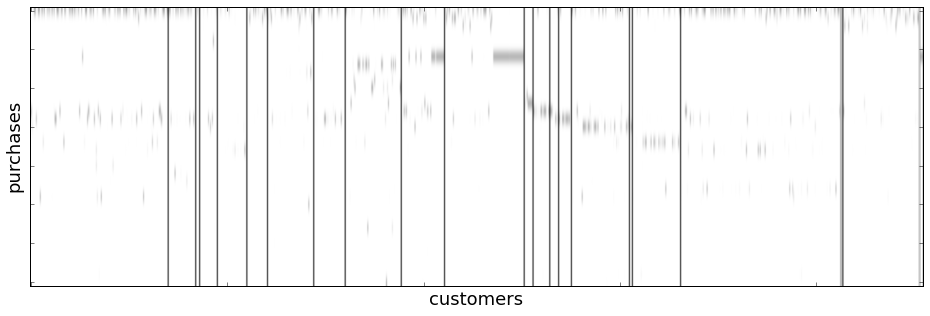

In [17]:
plt.figure(figsize=(16, 5))
plt.rcParams["font.size"] = 18
plt.imshow(rslt.T, cmap='Greys', interpolation='bicubic', aspect='auto')
plt.tick_params(labelbottom='off')
plt.tick_params(labelleft='off')
plt.ylabel('purchases')
plt.xlabel('customers')

In [18]:
rslt = np.empty((0, len(track_dic)+1), dtype=float)
tmp = []
for c in range(max_class):
    receipt_id = rct[max_lbl==c, 0]
    pprob = np.zeros((len(receipt_id), len(track_dic)+1), dtype=float)
    
    for r in range(len(receipt_id)):
        matcher = {'_id': receipt_id[r] }
        res = db['track'].find(matcher, {'_id':1,'data.node_id':1, 'data.duration':1}).sort([('data.ts',pymongo.ASCENDING), ('data.ts_ms', pymongo.ASCENDING)])
        for item in res:
            for data in item['data']:
                pprob[r, node_id[data['node_id']]] += 1
    if pprob.shape[0]:
        pprob = np.apply_along_axis(lambda x: x/sum(x), 1, pprob)
        tmp.append(pprob)

for i in np.argsort(odr):
    rslt = np.r_[rslt, tmp[i]]
    rslt = np.r_[rslt, np.ones((1, len(track_dic)+1), dtype=float)*.15]

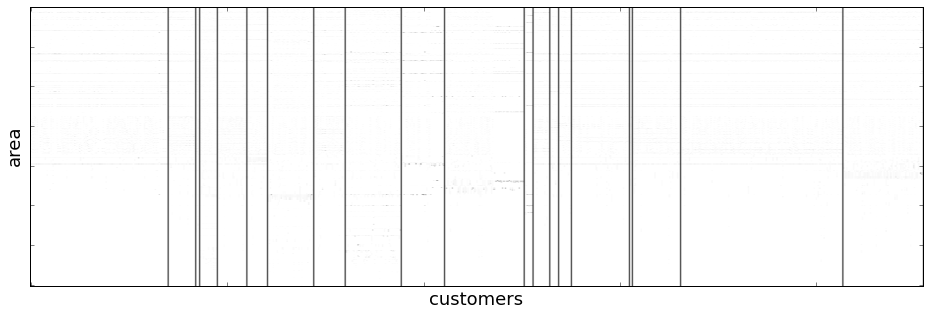

In [19]:
plt.figure(figsize=(16, 5))
plt.rcParams["font.size"] = 18
plt.imshow(rslt.T, cmap='Greys', interpolation='bicubic', aspect='auto')
plt.tick_params(labelbottom='off')
plt.tick_params(labelleft='off')
plt.ylabel('area')
plt.xlabel('customers')

## クラスタリング結果をファイルに保存

In [20]:
for i in range(max_class):
    basket_id = rct[max_lbl==i, 0]
    pd.DataFrame(basket_id).to_csv("lda_%02d.csv" % i, sep=",", header=False, index=False) 

In [21]:
# カテゴリの商品ジャンル名辞書の構築
def build_category_dic():
    out = []
    dummy = {}
    res = db['category'].find()
    for i in range(res.count()):
        t = [i, i, 1]
        out = out + [t]
    out = pd.DataFrame(np.array(out))
    out.iloc[:,1] = out.iloc[:,1].astype(str)
    cat_map = {}
    key = 0
    for item in res:
        cat_map[item['_id']] = key
        i = key
        key += 1
        if item['cat_name'] in dummy.keys():
            dummy[item['cat_name']] += 1
            out.iat[i,1] = item['cat_name'].encode('utf-8') + str(dummy[item['cat_name']])
        else:
            dummy[item['cat_name']] = 0
            out.iat[i,1] = item['cat_name'].encode('utf-8')   
    out.to_csv("category_name.csv", encoding='utf-8', index=False, header=False, sep='\t')
    dic = corpora.Dictionary.load_from_text("category_name.csv")
    return (cat_map, dic)
cat_map, cat_dic = build_category_dic()

## 来店動機商品群、置き換え対象商品群の選定

In [22]:
purchase = {}
matcher = {'date': {'$gte': start_date, '$lt': end_date}}
for c in range(max_class):
    basket_id = rct[max_lbl==c, 0]
    p_count = {}
    for r in basket_id:
        matcher = {'basket_id': r}
        if pos_repeat is True:
            res = db['pos'].find(matcher, {'cat_id':1, 'num':1})
            for item in res:
                #if int(res[j]['cat_id']) == 977 or int(res[j]['cat_id']) == 978:
                    #continue
                if p_count.has_key(item['cat_id']):
                    p_count[item['cat_id']] += 1
                else:
                    p_count[item['cat_id']] = 1 
                if int(item['num']) > 1:
                    for i in range(int(item['num'])-1):
                        p_count[item['cat_id']] += 1
        else:
            res = db['pos'].aggregate([
                    {'$match': matcher },
                    {'$group':{
                        '_id': {'cat_id': '$cat_id'},
                        'num': {'$sum': '$num'}
                    }}
                ])
            for item in res:
                #if int(res[j]['_id']) == 977 or int(res[j]['_id']) == 978:
                    #continue
                if p_count.has_key(item['_id']):
                    p_count[item['_id']] += 1
                else:
                    p_count[item['_id']] = 1 
                    
    # 一人当たり平均購入個数に変換
    for p in p_count:
        p_count[p] = 1.0 * p_count[p] / len(basket_id)
    purchase[c] = p_count

In [23]:
# 来店動機商品群は、評価対象から外す
main = set([]) 
for g in purchase:
    pop = purchase[g]
    pp = 1.
    for k, v in sorted(pop.items(), key=lambda x:x[1], reverse=True):
        if pp == 1 or pp * .75 < v:
            main = main | set([k])
            pp = v
        else:
            break
buff = []
for m in main:
    try:# cat_id が　0 の場合対応
        buff.append(cat_dic[cat_map[m]])
    except:
        pass
for b in sorted(buff):
    print b

グローサリー
ペット
和日配
家電
洋日配
菓子
飲料


In [24]:
# 置き換え対象商品群を抽出
sub = {}
sub_set = set([])
for g in purchase:
    pop = purchase[g]
    sub[g] = []
    for k, v in sorted(pop.items(), key=lambda x:x[1], reverse=True):
        if k in main:
            continue
        if v < .05: # 購入確率が低すぎる商品は無視する
            break
        sub[g].append(k)

buff = set([])
for g in sub:
    for s in sub[g]:
        buff |= set([cat_dic[cat_map[s]]])
        sub_set |= set([s])
print len(buff)
for b in sorted(buff):
    print b

24
1Fレジ前
DIY・園芸
はきもの
アイス
インテリア
インナー
カー用品
クラフト
スポーツ・レジャー
ドラッグ
パン
レディースアウター
ワーク
冷凍食品
加工肉
塩干
惣菜
文具
服飾アクセ
生活消耗
生活雑貨
米
軽家具・収納
酒


## お互いに場所を交換することで、評価値が向上する商品の組み合わせ探索

In [25]:
def get_shelf(category):
    ''' 商品カテゴリの置かれた棚ＩＤリスト取得
    '''
    shelf_id_list = db['shelf'].distinct('_id', {'cat_id':category})
    result = list(set(shelf_id_list).intersection(node_all_shelfs))
    return result

In [26]:
def get_shelf_prob(shelf, track):
    ''' あるグループの動線で、指定した棚前を通る確率
    '''
    p = 0.0
    for item in shelf_dic[str(shelf)]:
        p += track[node_id[str(item)]]    
    return p

In [27]:
# グループの人数比率の計算
gprob = 1.0 * np.unique(max_lbl, return_counts=True)[1] / len(max_lbl)
print np.unique(max_lbl)
print len(gprob)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
20


In [28]:
def get_shelf_prob_all(shelf, category):
    ''' 全ての購買グループでの、棚通過確率の期待値を求める
    '''
    prb = Decimal(0.0)
    for i in range(max_class):
        if purchase[i].has_key(category):
            bprob = purchase[i][category]
        else:
            bprob = 0.0
        prb += Decimal(gprob[i] * get_shelf_prob(shelf, track[i]) * bprob)
    return prb 

In [29]:
def get_better_shelf(category):
    ''' 
    '''
    sh = get_shelf(category)
    hypo = {}
    for s in sh:
        base_p = get_shelf_prob_all(s, category)
        if base_p == 0.0:
            continue

        for s2 in shelfid_list:
            if s == s2:
                continue
            temp = get_shelf_prob_all(s2, category)
            if temp > base_p:
                hypo[(s,s2)] = [base_p, temp]
    return hypo

In [30]:
def get_increment_id(collection):
    res = db['counter'].find_one_and_update({"_id": collection}, update={ "$inc": {'counter': 1}},upsert=True)
    if res:
        return res['counter']
    else:
        return 0

In [31]:
# 各グループごとのエリア滞在確率(を求める
track = {}

for g in range(max_class):
    basket_id = rct[max_lbl==g, 0]
    track[g] = {}
    count = np.zeros((len(track_dic)+1,), dtype=float)
   
    for ri in range(len(basket_id)):
        matcher = {'$and': 
                      [
                          { '_id': basket_id[ri] },
                          { 'data.duration': {'$gt': 5}}
                       ]
                   }
        res = db['track'].find(matcher, {'data.node_id':1, 'data.duration':1}).sort([('data.ts',pymongo.ASCENDING),('data.ts_ms',pymongo.ASCENDING)])
        for item in res:
            for data in item['data']:
                if data['duration'] > 5:
                    node = node_id[data['node_id']]
                    if node == 0:
                        continue
                    count[node] += 1
                    for j in range(int(data['duration']/20)): # 長時間滞在した場合は自己ループさせる
                        count[node] += 1
    # 一人当たり平均パス通過回数に変換
    #for n in range(len(count)):
    track[g] = 1.0 * count / len(basket_id) 

In [32]:
# 置き換え候補をグラフのエッジの形で構築する
Ex = nx.DiGraph()
for i in shelfid_list:
    Ex.add_node(i, pos=i)
for s in sub:
#for s in sorted(sub.keys())[0:3]:
    for c in sub[s]:
        hypo = get_better_shelf(c)
        for i, j in hypo:
            r = hypo[(i,j)][1] / hypo[(i,j)][0]
            try:
                w = Ex.edge[i][j]['weight']
                if r > w:
                    Ex.add_edge(i, j, weight=r, base_p=hypo[(i,j)][0], group=s, category=c)
            except:
                Ex.add_edge(i, j, weight=r, base_p=hypo[(i,j)][0], group=s, category=c)
    print "Round : {0}".format(s)

Round : 0
Round : 1
Round : 2
Round : 3
Round : 4
Round : 5
Round : 6
Round : 7
Round : 8
Round : 9
Round : 10
Round : 11
Round : 12
Round : 13
Round : 14
Round : 15
Round : 16
Round : 17
Round : 18
Round : 19


In [33]:
# レイアウト最適化探索条件テーブル登録
if condid != None:
    db['swap_candidate'].delete_many({'condid':condid})
else:
    condid = get_increment_id('layout_opt_cond')
    layout_opt_cond={}
    layout_opt_cond['_id'] = condid
    layout_opt_cond['time_from'] = start_date
    layout_opt_cond['time_to'] = end_date
    db['layout_opt_cond'].insert_one (layout_opt_cond)

In [34]:
def catid2shelfid(cat_id_list):
    catid_shelfid_dic = {}
    res = db['shelf'].find({'cat_id':{'$in':cat_id_list}},{'cat_id':1, '_id':1})
    for item in res:
        if item['cat_id'] not in catid_shelfid_dic.keys():
            catid_shelfid_dic[item['cat_id']] = []
        catid_shelfid_dic[item['cat_id']].append(item['_id'])
    return catid_shelfid_dic

In [35]:
# 双方向のつながりを持つエッジ(=交換可能）を抽出する
done = {}
tup_hyoukati=[]   #b/a keyとして対応のkを格納
check = nx.get_edge_attributes(Ex, 'weight')

for k in check:
    if check.has_key((k[1], k[0])):
        if done.has_key((k[1], k[0])):
            continue
        done[k] = 0
        done[(k[1], k[0])] = 0
        a = Ex.edge[k[0]][k[1]]['base_p'] + Ex.edge[k[1]][k[0]]['base_p']
        b = Ex.edge[k[0]][k[1]]['weight'] * Ex.edge[k[0]][k[1]]['base_p'] + Ex.edge[k[1]][k[0]]['weight'] * Ex.edge[k[1]][k[0]]['base_p']
        try:
            tup_hyoukati.append((b/a, k))
        except:
            continue

swap_candidate_list = []
if tup_hyoukati:
    tup_hyoukati = sorted(tup_hyoukati, key=lambda tup: tup[0], reverse=True) 
    for item in tup_hyoukati:
        k = item[1]
        cat_id_before = Ex.edge[k[0]][k[1]]['category']
        cat_id_after = Ex.edge[k[1]][k[0]]['category']
        
        a = Ex.edge[k[0]][k[1]]['base_p'] + Ex.edge[k[1]][k[0]]['base_p']
        b = Ex.edge[k[0]][k[1]]['weight'] * Ex.edge[k[0]][k[1]]['base_p'] + Ex.edge[k[1]][k[0]]['weight'] * Ex.edge[k[1]][k[0]]['base_p']
        print "a,b:",a, b
        print '%s,%s,%.2f' % \
              (cat_dic[cat_map[Ex.edge[k[0]][k[1]]['category']]], cat_dic[cat_map[Ex.edge[k[1]][k[0]]['category']]], b/a)
        
        swapset_id = get_increment_id('swapset_id')
        # エントリ１
        swap_candidate = {}
        swap_candidate['_id'] = get_increment_id('swap_candidate') # 入替え候補ID（このデータを一意に指定）
        swap_candidate['condid'] = condid   # 条件ID（どの条件IDにひもづくかを示す
        swap_candidate['swapset_id'] = swapset_id  # 入替えの組を表すID
        swap_candidate['category'] = cat_id_before  # 入替え商品のカテゴリー
        swap_candidate['jan'] = ''  # 入替え商品のJANコード
        swap_candidate['shelf'] = ''  # 入替え商品の棚コード
        swap_candidate['shelfid_from'] = k[0]  # 入替え前の棚番号
        swap_candidate['shelfid_to'] = k[1]  # 入替え後の棚番号
        swap_candidate['val_before'] = float(Ex.edge[k[0]][k[1]]['base_p'])  # 入替え前の評価値
        swap_candidate['val_after'] = float(Ex.edge[k[0]][k[1]]['weight']) * float(Ex.edge[k[0]][k[1]]['base_p'])
        swap_candidate_list.append(swap_candidate)
        # エントリ2
        swap_candidate = {}
        swap_candidate['_id'] = get_increment_id('swap_candidate') # 入替え候補ID（このデータを一意に指定）
        swap_candidate['condid'] = condid   # 条件ID（どの条件IDにひもづくかを示す
        swap_candidate['swapset_id'] = swapset_id  # 入替えの組を表すID
        swap_candidate['category'] = cat_id_after  # 入替え商品のカテゴリー
        swap_candidate['jan'] = ''  # 入替え商品のJANコード
        swap_candidate['shelf'] = ''  # 入替え商品の棚コード
        swap_candidate['shelfid_from'] = k[1]  # 入替え前の棚番号
        swap_candidate['shelfid_to'] = k[0]  # 入替え後の棚番号
        swap_candidate['val_before'] = float(Ex.edge[k[1]][k[0]]['base_p'])  # 入替え前の評価値
        swap_candidate['val_after'] = float(Ex.edge[k[1]][k[0]]['weight']) * float(Ex.edge[k[1]][k[0]]['base_p'])
        swap_candidate_list.append(swap_candidate)
        if len(swap_candidate_list) == 10:
            break
if swap_candidate_list:
    # 商品入替え候補テーブルの登録
    db['swap_candidate'].insert_many(swap_candidate_list)

a,b: 0.02575469387782523636735900613 0.1319782598304716746129283678
生活消耗,ドラッグ,5.12
a,b: 0.02690061558312113011237967641 0.1307683148285635010930200162
生活消耗,ドラッグ,4.86
a,b: 0.02690061558312113011237967641 0.1307683148285635010930200162
ドラッグ,生活消耗,4.86
a,b: 0.02491736464454817712534974439 0.1209829395105075524165585965
ドラッグ,生活消耗,4.86
a,b: 0.02491736464454817712534974439 0.1209829395105075524165585965
生活消耗,ドラッグ,4.86


## 置き換え対象商品群全体で、最適な配置を求める

In [ ]:
# 後続処理は最適配置の算出のため、一旦ここで処理を停止
sys.exit()

In [ ]:
# 既存の商品・棚ペアをテーブル可しておく
p_sh = {}
for c in sub_set:
    if get_shelf(c):
        p_sh[c] = set(get_shelf(c))

In [ ]:
OptG = nx.Graph()

# オリジナルの商品・棚の組み合わせを2部グラフ化
shelf_node = []
w_base = 0.
e_base = 0
for c in sub_set:
    sh = get_shelf(c)        # その商品が置かれている棚
    for i in range(len(sh)):  
        i_node = 'I%d.%d' % (int(c), i)
        OptG.add_node(i_node) # 置き換え対象商品のノード作成
        shelf_node.append(sh[i])
        s_node = 'S%d.%d' % (int(sh[i]), int(c))
        w = get_shelf_prob_all(sh[i], c)
        w_base += w
        e_base += 1
        OptG.add_edge(i_node, s_node, weight=w, orig=1)


In [ ]:
# 置き換え可能な商品と棚の間に、評価値に基づくエッジを張る
for c in sub_set:
    for n in OptG.nodes_iter():
        if re.match('^S', n):
            s = int(re.search('^S(.*)\.', n).groups()[0])
            if c not in p_sh.keys():
                continue
            if s in p_sh[c]:
                continue
            #if s == 42 or s == 43: # レジで売るものの場所は変えない
                #continue
            w = get_shelf_prob_all(s, c)
            
            sh = get_shelf(c)        # その商品が置かれている棚
            for i in range(len(sh)):  
                i_node = 'I%d.%d' % (int(c), i)            
                OptG.add_edge(i_node, n, weight=w, orig=0)  

In [ ]:
# 最適解の探索
match = nx.max_weight_matching(OptG, True)

In [ ]:
# 結果表示 (移動が無い場合は除外)
e_new = 0
w_new = 0.
chg = 0
for m in match:
    if re.match('^S', m):
        continue
    e_new += 1
    w_new += OptG.edge[m][match[m]]['weight']
    item = re.match('^I(.*)\.', m).groups()[0]
    tmp = re.match('^S(.*)\.(.*)', match[m]).groups()
    if item == tmp[1]: # 移動なし
        continue
    chg += 1
    print '%s,%s  /  %s,%s' % (cat_dic[int(item)], cat_dic[int(tmp[1])], m, match[m])
    
print e_base, e_new # 商品・棚の組み合わせ数に変化はないか
print w_base, w_new, w_new/w_base # 評価値はどう変化したか

In [ ]:
# 商品の置き場所が変わったものの辞書を作る
replace = {}
for m in match:
    if re.match('^S', m):
        continue
    item = int(re.match('^I(.*)\.', m).groups()[0]) # 対象商品
    shlf = int(re.match('^S(.*)\.(.*)$', match[m]).groups()[0]) # 置き場所
    w = OptG.edge[m][match[m]]['weight']
    if str(item) not in p_sh.keys():
        continue
    if shlf in p_sh[str(item)]:
        continue
    if replace.has_key(item):
        if w > replace[item][1]:
            replace[item] = [shlf, w]
        #replace[item] += [shlf]
    else:
        replace[item] = [shlf, w]
        #replace[item] = [shlf]

## 結果を可視化する

In [ ]:
# 棚ID（shelf_id)の中心位置を格納したテーブルの作成
shelf_pos = {}
res = db['shelf'].find({},{'_id':1, 'x':1, 'y':1})
for item in res:
    shelf_pos[item['_id']] = [item['x'], item['y']]


In [ ]:
# 描画対象グループ
gid = 12

# グループ内で買われた商品で、置き換え対象商品なもの
pset = set(purchase[gid].keys())
target = sub_set & pset

In [ ]:
# 置き換えが発生しているかどうか確認
for t in target:
    data = {}
    if t == 0:
        continue
    old = get_shelf(t)
    if replace.has_key(int(t)):
        new = replace[int(t)][0]
        print t, cat_dic[int(t)], ': ', old, ' -> ', new

In [ ]:
# グラフとして図示
fig = plt.figure(figsize=(20,10))
plt.rcParams["font.size"] = 20
color = np.random.randint(0, 100, 50)
color = np.random.randint(0,255,(500,3))
for g in range(2):
    ax = fig.add_subplot(1, 2, g+1)

    ax.tick_params(labelbottom='off')
    ax.tick_params(labelleft='off')
    # 行動可能エリアの矩形を描画する
    #a = np.array(Area.values())
    #xlim= [np.min(a[:,0])-500, np.max(a[:,2])+500]
    #ylim= [np.max(a[:,3])+50, np.min(a[:,1])-500]
    xmin=xmax=ymin=ymax=0 
    for i,item in enumerate(Area):
        if i == 0:
            xmin=xmax=int(Area[item]['x0'])
            ymin=ymax=int(Area[item]['y0'])
        else:
            if int(Area[item]['x0']) < xmin:
                xmin = int(Area[item]['x0'])
            if int(Area[item]['x0']) > xmax:
                xmax = int(Area[item]['x0'])
            if int(Area[item]['y0']) < ymin:
                ymin = int(Area[item]['y0'])
            if int(Area[item]['y0']) > ymax:
                ymax = int(Area[item]['y0'])
    xlim= [xmin-500, xmax+500]
    ylim= [ymax+50, ymin-500]
        
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    for k in Area.keys():
        rec = Area[k]
        ax.add_patch( plt.Rectangle(xy=[int(rec['x0']), int(rec['y0'])], width=500, height=300, fill=True, facecolor='#b0b0b0', alpha=0.1) )
        #ax.add_patch( plt.Rectangle(xy=[rec[0], rec[1]], width=rec[2]-rec[0], height=rec[3]-rec[1], fill=True, facecolor='#b0b0b0', alpha=0.1) )
        # ax.text((rec[0]+rec[2])/2, (rec[1]+rec[3])/2+100, k, ha='center', va='top')


    # エッジ, ノードの色と大きさを決める
    val = []
    for i,j in G.edges_iter(data=False):
        w = (track[gid][int(node_id[str(i)])] + track[gid][int(node_id[str(j)])])/2.
        val.append(w)
    val = np.array(val)
    ewidth = map(lambda x: min(5, max(x, 0.1)), np.log10(val + 1e-10)*2.5+5)
    ecolor = val

    # パス頻度の塗り分け
    pos = nx.get_node_attributes(G, 'pos')
    nc = nx.draw_networkx_edges(G, pos=pos, width=ewidth, 
                           edge_cmap=plt.cm.Greys, edge_color=val, edge_vmin=-1, arrows=False, alpha=0.8)
    
    same = {}
    if g == 0:
        # 買われた商品の置き場所
        for i in range(len(target)):
            t = list(target)[i]
            if t == 0:
                continue
            if not get_shelf(t):
                continue
            s = get_shelf(t)[0] # 複数ある時はそのうちの１つのみ
            r = (np.log(purchase[gid][t]) + 8) * 40.
            c = '#%02x%02x%02x' % tuple(color[i])
            x, y = shelf_pos[s]
            if same.has_key(s):
                same[s] += 1
                x += 150 * same[s]
            else:
                same[s] = 0
            ax.add_patch( plt.Circle([x, y], radius=r, color=c, alpha=0.8))
            ax.text(x, y+100, t, ha='center', va='top', size=18)
        ax.set_title('before')
    else:
        # 最適化後の商品の置き場所
        for i in range(len(target)):
            t = list(target)[i]
            if t == 0:
                continue
            if replace.has_key(t):
                s = replace[t][0]
            else:
                if not get_shelf(t):
                    continue
                s = get_shelf(t)[0]
            r = (np.log(purchase[gid][t]) + 8) * 40.
            c = '#%02x%02x%02x' % tuple(color[i])
            x, y = shelf_pos[s]
            if same.has_key(s):
                same[s] += 1
                x += 150 * same[s]
            else:
                same[s] = 0
            ax.add_patch( plt.Circle([x, y], radius=r, color=c, alpha=0.8))
            ax.text(x, y+100, t, ha='center', va='top', size=18)
        ax.set_title('after')